In [44]:
!pip install av
!pip install facenet_pytorch
!pip install ffmpeg-python
!pip install matplotlib

In [2]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
import facenet_pytorch
import matplotlib.pyplot as plt
import ffmpeg
import torchvision.io as tio
import av
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.video import r3d_18
from torchvision.transforms import functional as F
from torchvision import transforms
import math

c:\Users\Asus\Desktop\Phosphene.AI\sizeinvar_timesformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import zipfile
import os

#zip_file = "/content/drive/MyDrive/Phosphene/sample_data.zip"
#with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#        zip_ref.extractall()

In [13]:
train_dir = "sample_data/target/train"
val_dir = "sample_data/target/val"
train_mask_dir = "sample_data/target_mask/train"
val_mask_dir = "sample_data/target_mask/val"

In [130]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 171)),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989])
])

In [131]:
import random

class VideoDataset(Dataset):
    def __init__(self, directory, target_dir, transform=None, frame_rate=24, pick_only=24):
        self.directory = directory
        self.target_dir = target_dir
        self.transform = transform
        self.frame_rate = frame_rate
        self.pick_only = pick_only

        self.videos = sorted(os.listdir(self.directory))
        self.masks = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = os.path.join(self.directory, self.videos[idx])
        mask_path = os.path.join(self.target_dir, self.masks[idx])
    
        video_frames, mask_frames = self.extract_frames(video_path, mask_path)
        
        if self.transform:
            video_frames = [self.transform(frame) for frame in video_frames]
            mask_frames = [self.transform(frame) for frame in mask_frames]

        video_frames = torch.stack(video_frames).permute(1, 0, 2, 3)
        mask_frames = torch.stack(mask_frames).permute(1, 0, 2, 3)

        return video_frames, mask_frames

    def extract_frames(self, video_path, mask_path):
        cap_video = cv2.VideoCapture(video_path)
        cap_mask = cv2.VideoCapture(mask_path)
        frame_count = int(cap_video.get(cv2.CAP_PROP_FRAME_COUNT))
        desired_frame_count = self.pick_only
        
        # Pick a random starting point within the video 
        start_idx = random.randint(0, max(0, frame_count - desired_frame_count))
        
        video_frames = []
        mask_frames = []
        
        cap_video.set(cv2.CAP_PROP_POS_FRAMES, start_idx)  
        cap_mask.set(cv2.CAP_PROP_POS_FRAMES, start_idx)  
        
        for i in range(desired_frame_count):
            ret_video, frame_video = cap_video.read()
            ret_mask, frame_mask = cap_mask.read()
            if not (ret_video and ret_mask):
                break
            frame_video = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)
            frame_mask = cv2.cvtColor(frame_mask, cv2.COLOR_BGR2GRAY)
            video_frames.append(frame_video)
            
            mask_frames.append(frame_mask)
           
        
        cap_video.release()
        cap_mask.release()
        return video_frames, mask_frames


In [132]:
train_dataset = VideoDataset(train_dir, target_dir=train_mask_dir, transform=transform)
val_dataset = VideoDataset(val_dir, target_dir=val_mask_dir,transform=transform)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [133]:
video = None
count = 0

In [134]:
for videos, masks in train_loader:
    video = videos
    if count == 3:
        break
    count += 1
    print("Video batch shape:", videos.shape)
    print("Mask batch shape:", masks.shape)
    

RuntimeError: output with shape [1, 128, 171] doesn't match the broadcast shape [3, 128, 171]

In [21]:
video.shape

torch.Size([1, 3, 24, 224, 224])

In [9]:
len(train_dataset),len(val_dataset)

(517, 102)

In [117]:
pretrained = r3d_18(pretrained = True)

c:\Users\Asus\Desktop\Phosphene.AI\sizeinvar_timesformer\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\Desktop\Phosphene.AI\sizeinvar_timesformer\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
modules = list(pretrained.modules())

pretrained_sequential = nn.Sequential()

for _, module in enumerate(modules):
    pretrained_sequential.add_module('module' + str(_), module)

In [113]:
modules = list(modules[0].modules())

In [ ]:
modules[0].get_submodule()

In [116]:
modules

[VideoResNet(
   (stem): BasicStem(
     (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
     (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Sequential(
         (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
         (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
       (conv2): Sequential(
         (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
         (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (relu): ReLU(inplace=True)
     )
     (1): BasicBlock(
       (conv1): Sequential(
         (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bi

In [43]:
model = list(modules[0].modules())[:5]

In [49]:
len(list(model[0].modules()))

92

In [123]:
preprocess = transforms.Compose([
    transforms.Resize((128, 171)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989])
])

ValueError: If size is a sequence, it should have 1 or 2 values

In [124]:
out = pretrained_sequential(preprocess(video.permute(0,2,1,3,4)).permute(0,2,1,3,4))

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [3, 224, 224] and output size of [128, 171]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [78]:
out = out.reshape((1,20,20))

In [79]:
import matplotlib.pyplot as plt

In [80]:
out = out.permute(1,2,0).detach().numpy()

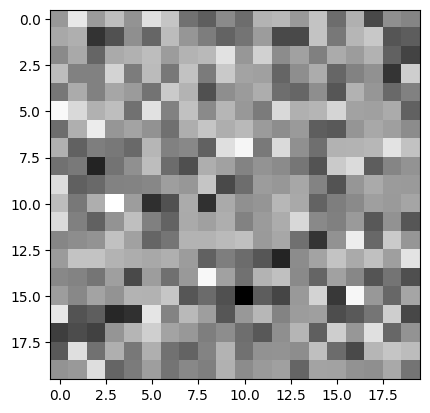

In [81]:
plt.imshow(out,cmap = "gray")

In [138]:
modules[:2][0]

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [6]:
pretrained_sequential[]

Sequential(
  (module0): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3

In [82]:
out.shape

(20, 20, 1)

In [139]:
features = []
layers = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5']
x = video
for name, module in model.named_children():
    x = module(x)
    if name in layers:
        features.append(x)


TypeError: conv3d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int, int)!, !tuple of (int, int, int)!, !tuple of (int, int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int, int)!, !tuple of (int, int, int)!, !tuple of (int, int, int)!, int)


In [ ]:
class VideoFeatureExtractor(nn.Module):

    def __init__(self,):
        self.resnet = r3d_18()

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x = self.decoder(x1)
        x = torch.sigmoid(x)

        return x


model = UNet()


In [92]:
encoder = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

In [95]:
decoder = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, 1, kernel_size=2, stride=2)
        )

In [96]:
o = encoder(videos)

In [99]:
torch.sigmoid(decoder(o))

tensor([[[[[0.4748, 0.4728, 0.4745,  ..., 0.4716, 0.4730, 0.4710],
           [0.4781, 0.4754, 0.4772,  ..., 0.4744, 0.4784, 0.4747],
           [0.4731, 0.4739, 0.4747,  ..., 0.4714, 0.4736, 0.4695],
           ...,
           [0.4780, 0.4743, 0.4788,  ..., 0.4757, 0.4799, 0.4740],
           [0.4721, 0.4727, 0.4740,  ..., 0.4717, 0.4737, 0.4704],
           [0.4800, 0.4753, 0.4804,  ..., 0.4766, 0.4798, 0.4754]],

          [[0.4788, 0.4702, 0.4788,  ..., 0.4673, 0.4767, 0.4663],
           [0.4789, 0.4778, 0.4782,  ..., 0.4778, 0.4789, 0.4780],
           [0.4818, 0.4690, 0.4823,  ..., 0.4662, 0.4775, 0.4662],
           ...,
           [0.4780, 0.4774, 0.4758,  ..., 0.4766, 0.4767, 0.4766],
           [0.4783, 0.4694, 0.4774,  ..., 0.4672, 0.4770, 0.4684],
           [0.4777, 0.4777, 0.4773,  ..., 0.4787, 0.4776, 0.4784]],

          [[0.4756, 0.4720, 0.4733,  ..., 0.4719, 0.4732, 0.4717],
           [0.4788, 0.4774, 0.4814,  ..., 0.4737, 0.4800, 0.4749],
           [0.4750, 0.4726

In [102]:
model = model.to(device)

In [103]:
model(video.to(device))

tensor([[[[[0.4947, 0.5037, 0.4958,  ..., 0.5023, 0.4947, 0.5026],
           [0.5003, 0.5025, 0.5011,  ..., 0.5030, 0.5022, 0.5054],
           [0.4938, 0.5021, 0.4965,  ..., 0.5033, 0.4939, 0.5030],
           ...,
           [0.4966, 0.5042, 0.4967,  ..., 0.5042, 0.4999, 0.5040],
           [0.4931, 0.5037, 0.4938,  ..., 0.5043, 0.4928, 0.5048],
           [0.4955, 0.5052, 0.4941,  ..., 0.5048, 0.4987, 0.5033]],

          [[0.5056, 0.4909, 0.5054,  ..., 0.4914, 0.5062, 0.4924],
           [0.4939, 0.4981, 0.4911,  ..., 0.4994, 0.4932, 0.4977],
           [0.5071, 0.4900, 0.5052,  ..., 0.4894, 0.5051, 0.4917],
           ...,
           [0.4946, 0.4997, 0.4929,  ..., 0.5002, 0.4929, 0.4954],
           [0.5074, 0.4906, 0.5071,  ..., 0.4877, 0.5047, 0.4894],
           [0.4963, 0.4993, 0.4960,  ..., 0.5001, 0.4953, 0.4950]],

          [[0.4949, 0.5026, 0.4969,  ..., 0.5025, 0.4955, 0.5033],
           [0.4984, 0.5025, 0.4977,  ..., 0.5003, 0.5014, 0.5031],
           [0.4943, 0.5024

In [12]:

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
print(type(model))
print(dir(model))

<class '__main__.UNet'>
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register

In [16]:
def dice_coefficient(y_true,y_pred):
    smooth = 1e-6
    intersection = torch.sum(y_true*y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth)/(union+smooth)
    return dice


In [ ]:
for epoch in range(5):
    model.train()
    epoch_loss = 0.0
    similarity_index = 0.0
    total_samples = 0
    
    for batch_idx, (videos, masks) in enumerate(train_loader):
        print(f"Epochs : {epoch+1}")
        videos, masks = videos.to(device), masks.to(device)
        print(f"Batch {batch_idx+1}/{len(train_loader)}")
        print(f"Video shape: {videos.shape}")
        print(f"Mask shape: {masks.shape}")

        optimizer.zero_grad()
        outputs = model(videos)
        print(f"Output shape: {outputs.shape}")

        loss = criterion(outputs, masks)
        print(f"Loss for batch {batch_idx+1}: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_size = videos.size(0)
        total_samples += batch_size
        
        #similarity index 
        outputs_binary = torch.sigmoid(outputs) > 0.5
        similarity_index += dice_coefficient(masks, outputs_binary).item() * batch_size

    avg_loss = epoch_loss / len(train_loader)
    avg_similarity_index = similarity_index / total_samples
    
    print(f'Epoch [{epoch+1}/{5}], Average Loss: {avg_loss:.4f}, Similarity Index: {avg_similarity_index:.4f}')

   

In [ ]:
model.eval()
val_loss = 0.0
val_iou = 0.0
total_val_samples = 0

        
with torch.no_grad():
    for batch_idx, (videos, masks) in enumerate(val_loader):
        videos, masks = videos.to(device), masks.to(device)
        outputs = model(videos)
        loss = criterion(outputs, masks)
        val_loss += loss.item()
            
        
            
        total_val_samples += videos.size(0)
    
avg_val_loss = val_loss / len(val_loader)
    
print(f'Validation Loss: {avg_val_loss:.4f}')


In [ ]:
EPOCH = epoch
PATH = "model.pt"
LOSS = val_loss

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
for videos, masks in train_loader:
      videos, masks = videos.to(device), masks.to(device)
      break
plt.imshow(transforms.ToPILImage()(outputs[0,:,3,:,:]))

In [ ]:
vid = outputs.cpu().permute(0,2,3,4,1).numpy()[0]
plt.imshow(vid[0,:,:,:])

In [ ]:
outputs.max()